In [1]:
"""
Created on Aug 2020

@author: Alejandro Bernardin S.
@github: Alejob
@mail  : abernardin@dlab.cl
"""
from class_SEIR import SEIR
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def mobility_matrix(dim_system, random_modulate=False, num_connected_nodes=None, diffusion=False, diff_value=None,
                    diagonal=False, symmetric=False, centralized=False, central_node=None, node_increment=None):
    """                 
    dim_system:  Integer 
                 Dimension of the mobility matrix
    random_modulate: Bool
                     matrix to set the number of connected nodes
    num_connected_nodes: Integer
                         Number of connected nodes in modulated matrix
    diffusion: Float
               Diffusion of the connected nodes. 0<diffusion<1
    diagonal:    Bool
                 Get a diagonal matrix
    symmetric:   Bool
                 Get a symmetric matrix
    centralized: Bool
                 Get a matrix with nodes with higher input mobility
    central_node: Array
                  Array of nodes that will receive a higher input
    node_increment: Double
                    Size that will be incremented the central nodes
    """
    if centralized:
        # random centralized mobility matrix
        P_syn        = np.random.rand(dim_system, dim_system)
        for i in central_node:
            P_syn[:,i]  *= node_increment                # multiply column i by node_increment
        P_syn        = P_syn/(P_syn.sum(1).reshape(-1,1)) 

    elif symmetric:
            # random symmetric matrix
            P_syn = np.random.rand(dim_system, dim_system)
            P_syn = P_syn/(P_syn.sum(1).reshape(-1,1))
            P_syn = (P_syn + P_syn.T)/2
            
    elif diagonal:
            # disconnected matrix, only diagonal values, ie only mobility in nodes
            P_syn = np.diag(np.repeat(1,dim_system))
            
    elif random_modulate:
            # random normalized matrix with only some nodes connected
            if num_connected_nodes<=1:
                print("Warning: Not connected nodes")
                
            # set diagonal with full population
            P_diag         = np.diag(np.repeat(1.0,dim_system))
            
            if diffusion==True:
                P_diag         = np.diag(np.repeat(0.0,dim_system))
                # Fill with diffusion the connected nodes
                for node_i in range(num_connected_nodes):
                    for node_j in range(num_connected_nodes):
                        if node_i != node_j:
                            
                            P_diag[node_i, node_j] = np.random.rand()#rand_ij
                            
                # replace zero value for one, to avoid zero division
                aux = P_diag.sum(1).reshape(-1,1)
                aux[aux==0]=1
                # Normalize the matrix
                P_syn = P_diag*diff_value/aux #(P_diag.sum(1).reshape(-1,1))
                P_syn = P_syn + (np.diag(np.repeat(1.0,dim_system)- P_syn.sum(1)))                
            else:
                # Fill randomly the connected nodes
                for node_i in range(num_connected_nodes):
                    for node_j in range(num_connected_nodes):
                        P_diag[node_i, node_j] = np.random.rand()
                        P_diag[node_j, node_i] = np.random.rand()
                # Normalize the matrix
                P_syn = P_diag/(P_diag.sum(1).reshape(-1,1))
                #print(P_syn)
        
    else:
            # random normalized mobility matrix
            P_syn = np.random.rand(dim_system, dim_system) # dim_system x dim_system matrix
            P_syn = P_syn/(P_syn.sum(1).reshape(-1,1))     # normalize the matrix, 1-> sum over rows

    def alpha_syn(t):
        return(np.ones([dim_system, dim_system])) #mobility in node
    
    return(P_syn)


def mobility_matrix_t(dim_system, time, repeat=False, repeat_period=None, add_repeat_period=None):
    """  
    dim_system    : Integer 
                     Dimension of the mobility matrix
    time          : Array
                     Array of timesteps in required units.
    repeat        : Bool
                     If some time interval will be repeated
    repeat_period : Integer
                     Period that will repeat until complete total time of simulation
    add_repeat_period: Integer
                        Period that will repeat at the end of repeat_period
                 
    """
    time_index = len(time)
    
    if repeat==True and add_repeat_period==None:
        
        timestep = int(time_index/time[-1])
        print("time index", time_index)
        print("time[-1]", time[-1])
        print("timestep", timestep)
        
        # Create the period to repeat
        # Create a random tensor of total time repeat_period, in timesteps (ex: 7 days=70 timesteps, if timestep=0.1)
        # If repeat_period=7 this is a week
        P_base = np.random.rand(repeat_period*timestep, dim_system, dim_system)
        # Normalize all the matrix of the tensor
        for i in range(repeat_period*timestep):
            P_base[i, :, :] = P_base[i, :, :]/P_base[i, :, :].sum(1).reshape(-1,1)
        
        """
        # for debugging
        count = 0
        for i in P_base:
            print(count)
            print("i=", i)
            count += 1
        #print("P_base", P_base)
        """
        
        # Times that repeat_period fit in time_index (ex: 4000timestep=time_index,repeat_period=7 => periodinsidetotal=571  )
        period_inside_total = int(time_index/repeat_period)
        print("period in total", period_inside_total)
        
        # Repeat the period until fill the total time
        P_syn = []
        for i in range(period_inside_total): # Improve this, the generated array is too long
        #for i in range(repeat_period+1):
            P_syn.append(P_base)
        
        print(np.shape(np.array(P_syn)))
        P_syn = np.array(P_syn).reshape(period_inside_total*repeat_period*timestep, dim_system, dim_system)
        #P_syn = np.array(P_syn).reshape(time_index, dim_system, dim_system)
        print(np.shape(np.array(P_syn)))
        P_syn = P_syn[:time_index]
        print(np.shape(np.array(P_syn)))
        
    elif repeat==True and add_repeat_period!=None: # para disminuir movilidad en realidad
        timestep = int(time_index/time[-1])
        total_period = repeat_period + add_repeat_period
        
        P_base = np.random.rand(total_period*timestep, dim_system, dim_system)
        
        # Normalize all the matrix of all the tensor
        for i in range(total_period*timestep):
            P_base[i, :, :] = P_base[i, :, :]/P_base[i, :, :].sum(1).reshape(-1,1)
            
        # Now increase mobility in node and decrease out node, in add_repeat_period
        for i in range(1,add_repeat_period*timestep):
            P_base[-i, :, :] = P_base[-i, :, :] + np.diag(np.repeat(10,dim_system))  # increse times 10, IMPROVE THIS
            P_base[-i, :, :] = P_base[-i, :, :]/P_base[-i, :, :].sum(1).reshape(-1,1)
        
        # Repeat the created period until fill the total time
        period_inside_total = int(time_index/total_period)
        P_syn = []
        for i in range(period_inside_total): # Improve this, the generated array is too long
            P_syn.append(P_base)
        
        P_syn = np.array(P_syn).reshape(period_inside_total*total_period*timestep, dim_system, dim_system)
        P_syn = P_syn[:time_index]

    else:
        P_syn = np.random.rand(time_index, dim_system, dim_system)
        P_syn = P_syn/(P_syn.sum(1).reshape(-1,1))
    
    return(P_syn)

# Synthetic data maker

This notebook receives parameters inputs and as output it delivers a csv table of the Infected state of each node of the system. It also outputs the mobility matrix. In this notebook we define our model and then we show the implementation.

### SEIR* model

We define the SEIR* model as a system with $N$ nodes that interact between them by a mobility matrix $P_{ij}$. The system is described by

$$\beta \hat{S}_i\sum_{j=1}^n\frac{{\hat P}_{ij}}{\hat{N}_j}\hat{I}_j=
\beta k_SS_i\sum_{j=1}^n\frac{P_{ij}\alpha_{ij}(t)}{(\sum_{k=1}^nP_{kj}\alpha_{kj}(t)N_k)}\sum_{l=1}^nP_{lj}\alpha_{lj}(t)I_l(\epsilon\kappa_S+(1-\epsilon)\kappa_I).$$

so the SEIR* system became 

\begin{equation}
    \begin{split}
\frac{dS_i}{dt} &= -\beta \hat{S}_i  \sum_{j=1}^n\frac{\hat{P}_{ij}}{{\hat{N}_j}}\hat{I}_j\\
\frac{dE_i}{dt} &= \beta \hat{S}_i  \sum_{j=1}^n\frac{\hat{ P}_{ij}}{{\hat{N}_j}}\hat{I}_j - \sigma E_i  \\
\frac{dI_i}{dt} &= \sigma E_i - \gamma I_i\\
\frac{dR_i}{dt} &= \gamma I_i\\
\label{SEIR*}
\end{split}
\end{equation}

for more information please refer to the SEIR* paper.

### Define parameters

First you should to define the parameters of the synthetic system. The biological parameters are:

- $\beta$: infection rate
- $\sigma$: exposed rate
- $\gamma$: recovery rate

the entropy parameters are:

- $\kappa_s$: Average risk of susceptible inhabitants
- $\kappa_i$: Average risk of infected inhabitants

and the mobility function:

- $\alpha(t)$: Mobility function matrix that change mobility of the system

In [3]:
# Biological parameters
beta = 0.3
sigma = 0.1
gamma = 0.1

# Entropy parameters
ks      = 1.0
ki      = 1.0

# Not used constant, yet
mu      = 0.0
epsilon = 1.0

# Mobility function. To modify mobility, modify this function

# Mobility not modified, alpha_syn(t) = 1 for all t
def alpha_syn(t): return(np.ones([dim_system, dim_system])) # modify mobility matrix

# 500 timestep with value 1, and the next 3500 timestep with value 0
#def alpha_syn(t): return(np.append(np.repeat(1,int(100)), np.repeat(0.1,int(3900)))[int(t)])

## Add noise to the system 

We add noise to the output of all states. We set a gaussian noise with mean `mean` and standar deviation `std_dev`. If `add_noise=False`, we turn off the noise.

In [4]:
# Gaussian noise
add_noise = True
mean      = 0
std_dev   = 3

### Size of the system
Now you should set dimension of the system, in other words, the number of nodes of the system.

In [5]:
# Dimension of the system
dim_system = 1

### Mobility matrix
Here we define the mobility matrix $P_{ij}$ that will connect our system. We have two ways to create our $P_{ij}$, the first is randomly and the second is creating a handmade matrix. It is worth noting that $P_{ij}$ is a normalized by rows matrix. Here we show a random created matrix and its graphical representation. We also show a plot that tells us which are the nodes that have a greater probability of accept people **before** set people in nodes.

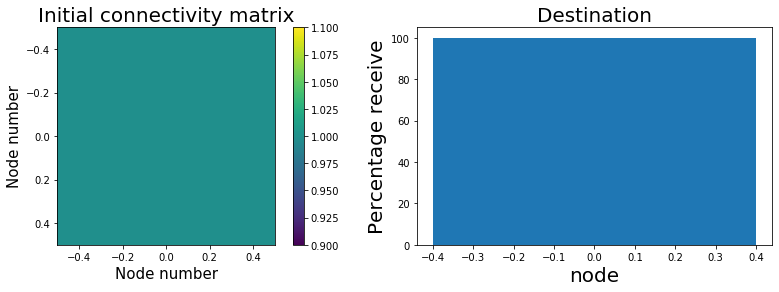

In [6]:
# Synthetic matrix
P_syn = mobility_matrix(dim_system)

# Plot
plt.rcParams["figure.figsize"] = 14, 4

# Mobility matrix
plt.subplot(1,2,1)
plt.imshow(P_syn)
plt.colorbar()
plt.title("Initial connectivity matrix", size=20)
plt.xlabel("Node number", size=15)
plt.ylabel("Node number", size=15)

# Destination
plt.subplot(1,2,2)
plt.bar(np.arange(dim_system), P_syn.sum(0)*100/dim_system) # Sum over columns
plt.title("Destination", size=20)
plt.xlabel("node", size=20)
plt.ylabel("Percentage receive", size=20)
plt.show()

### Simulation time
Now we define the simulation time in days and the timestep of the integrator. If we need our simulation in other units, hours, for example, we should modify the biological parameters of the system.

In [7]:
time     = np.arange(401) #Days
timestep = 0.1

### Initial states of the system
Here we define the initial states of the system. The initial states of the system are:

- $S_0$: Initial number of susceptibles
- $E_0$: Initial number of exposed
- $I_0$: Initial number of infected
- $R_0$: Initial number of removed

We have set $500$ initial susceptible per node and $50$ infected in node $0$. This initial state vector should be normalized. We also set the total population number $N$ wich is given by the sum of all the states of the system.

$$ N = S_0+E_0+I_0+R_0 $$

In [8]:
S0 = np.full(dim_system,500) # 500 persons per node
# Normalize S0
total_susceptible = S0.sum()
S0 = total_susceptible * S0/S0.sum()

E0 = np.zeros(dim_system)
I0 = np.zeros(dim_system)
R0 = np.zeros(dim_system)

# Set initial infected
I0[0] = 50                   # 50 initial infected persons in node 0
# Normalize I0
I0    = I0 * I0/I0.sum()

# Total population
N = S0+E0+I0+R0

### Integrate the equations
Now we integrate the equations. Here we also define some constants and function that are not currently being used.

In [9]:
# Integrate the system
model_syn = SEIR(P_syn,alpha_syn,S0, E0, I0, R0, 
                beta, sigma, gamma, mu, epsilon, ks, ki)

model_syn.integr(min(time),max(time),0.1, False)

Scikit couldn't be imported. Using RK4 instead


### Add noise to the output

In [10]:
total_timestep = int(max(time)/timestep) + 1

if add_noise == True:
    # Add gaussian noise
    for i in range(dim_system):
        model_syn.S[i] = model_syn.S[i] + np.random.normal(mean, std_dev, total_timestep)
        model_syn.E[i] = model_syn.E[i] + np.random.normal(mean, std_dev, total_timestep)
        model_syn.I[i] = model_syn.I[i] + np.random.normal(mean, std_dev, total_timestep)
        model_syn.R[i] = model_syn.R[i] + np.random.normal(mean, std_dev, total_timestep)
        
    # Set values < 0 as 0
    for i in range(dim_system):
        model_syn.S[i][model_syn.S[i] < 0] = 0
        model_syn.E[i][model_syn.E[i] < 0] = 0
        model_syn.I[i][model_syn.I[i] < 0] = 0
        model_syn.R[i][model_syn.R[i] < 0] = 0

### Transform output of integrator to regular unit of time
Transform output of the integrator, that it is delivery in timestep, in the units defined by user, in this case days.

In [11]:
jump_timestep = int(total_timestep/time[-1])  # show in units define by user, in this case days

"""
for i in range(dim_system):
        model_syn.S[i] = model_syn.S[i][::jump_timestep]
        model_syn.E[i] = model_syn.E[i][::jump_timestep]
        model_syn.I[i] = model_syn.I[i][::jump_timestep]
        model_syn.R[i] = model_syn.R[i][::jump_timestep]
"""

'\nfor i in range(dim_system):\n        model_syn.S[i] = model_syn.S[i][::jump_timestep]\n        model_syn.E[i] = model_syn.E[i][::jump_timestep]\n        model_syn.I[i] = model_syn.I[i][::jump_timestep]\n        model_syn.R[i] = model_syn.R[i][::jump_timestep]\n'

### Sum the output
Here we sum the output of each node to have the total output of the system, ie., a general view of the system.


In [12]:
# Sum all states to compare with one node
S0_sum = 0
E0_sum = 0
I0_sum = 0
R0_sum = 0

for i in range(dim_system):
    S0_sum += model_syn.S[i]
    E0_sum += model_syn.E[i]
    I0_sum += model_syn.I[i]
    R0_sum += model_syn.R[i]

### Visualization
We plot the result of all the states of our system. Each curve represent a different node of the system. We also plot how many people are in each node.

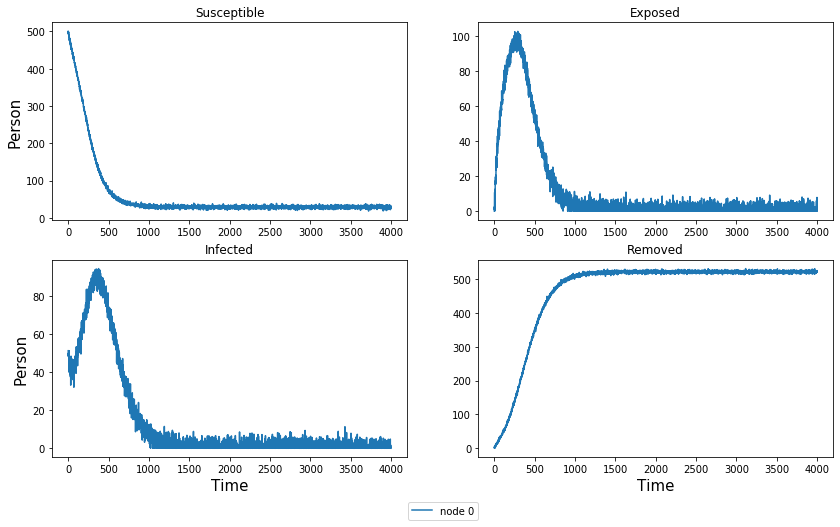

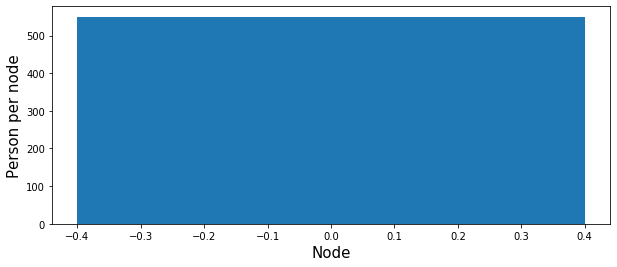

In [13]:
plt.rcParams["figure.figsize"] = 14, 8

plt.subplot(2,2,1)
#Plot all Susceptible
for i in range(dim_system):
    plt.plot(model_syn.S[i])
    
plt.title("Susceptible")
plt.ylabel("Person", size=15)

plt.subplot(2,2,2)
#Plot all Exposed
for i in range(dim_system):
    plt.plot(model_syn.E[i])

plt.title("Exposed")  

plt.subplot(2,2,3)
#Plot all Infected
for i in range(dim_system):
    plt.plot(model_syn.I[i])

plt.title("Infected")
plt.ylabel("Person", size=15)
plt.xlabel("Time"  , size=15)  

plt.subplot(2,2,4)
#Plot all Removed
for i in range(dim_system):
    plt.plot(model_syn.R[i], label="node {}".format(i))

plt.title("Removed")
plt.xlabel("Time", size=15)

plt.legend(bbox_to_anchor=(-0.1, -0.2), loc="upper center", ncol=4)

plt.show()

plt.rcParams["figure.figsize"] = 10, 4
plt.bar(np.arange(dim_system), (P_syn*(S0+I0)).sum(0))
plt.xlabel("Node", size=15)
plt.ylabel("Person per node", size=15)

plt.show()

### Output
We define how our data will be exported. Here we create a pandas DataFrame and then export to a csv file. We will export the active infected and the mobility matrix $P_{ij}$.


In [14]:
# We create an empty DataFrame
df = pd.DataFrame()

# We fill the DataFrame with the infected per node
for node in range(dim_system):
    df["node {}".format(node)] = model_syn.I[node][::jump_timestep]
    
df.to_csv("infected_active.csv")

# We also save the mobility matrix P_ij
df_P_matrix = pd.DataFrame()
df_P_matrix.to_csv("mobility_matrix.csv")

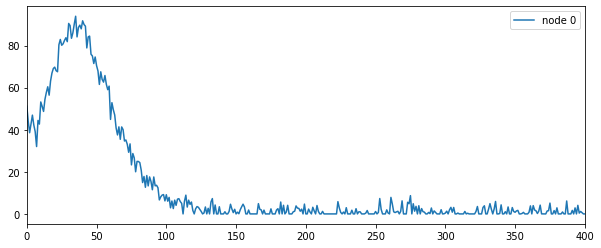

In [15]:
df.plot()

max 94.22078379982202
argmax 376


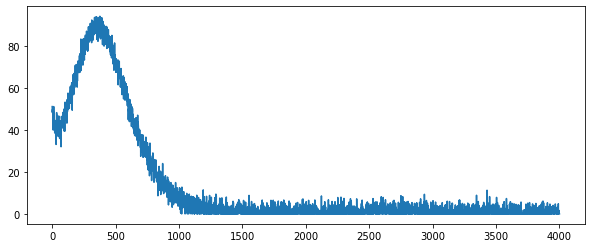

In [16]:
plt.plot(model_syn.I[0])
print("max", np.max(model_syn.I[0]))
print("argmax", np.argmax(model_syn.I[0]))

max 94.22078379982202
argmax 376


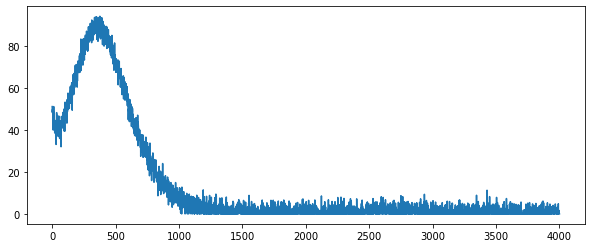

In [17]:
plt.plot(model_syn.I[0])
print("max", np.max(model_syn.I[0]))
print("argmax", np.argmax(model_syn.I[0]))